# Experiment for change point detection

Based on [Gaussian Process Change Point Models](https://mlg.eng.cam.ac.uk/pub/pdf/SaaTurRas10.pdf)

## Stuff learned
1. If we're looking for changes in slope, use the slopes as the time series data rather than the observations themselves
2. I'm so glad I don't have to implement it myself because that would have taken days

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import changepoint

## Experimental Setup
We're going to try and get obvious change points to be detected. Specifically, I think we'll be interested in finding changes in slope (maybe) and changes in value directly. Perhaps shot probabilities are low until a certain point when a striker enters the field, at which point shot probabilities increase dramatically.

We manually create data with a sharp change in slope at a known time.

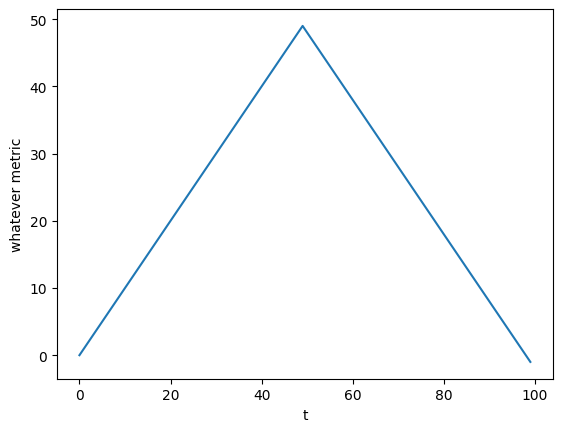

In [44]:
# controlled change points
n = 100
switch_point = n // 2

x_data = np.arange(n)
y_data = np.zeros(n)
start_slope = 1
after_slope = -1

for i in range(1, len(y_data)):
    if i < switch_point:
        y_data[i] = y_data[i-1] + start_slope
    else:
        y_data[i] = y_data[i-1] + after_slope


plt.plot(x_data, y_data)
plt.xlabel("t")
plt.ylabel("whatever metric")
plt.show()

## Change Point Detection

In [41]:
# code stolen from 
# https://github.com/promised-ai/changepoint/blob/master/pychangepoint/ChangePointExample.ipynb
# The repository for changepoint

def change_point_plot(data, change_point_history):
    """Plot the data and change point history with Maximum APosterori change-points"""

    fig, [data_ax, change_point_ax] = plt.subplots(
        2, 1, sharex=True, constrained_layout=True
    )

    data_ax.plot(data)

    data_ax.set_ylabel("data")
    change_point_ax.set_ylabel("$r_t$ (Run Length)")
    data_ax.set_xlim(0, len(data))

    np.sum(change_point_history, axis=1)

    cp_y_upper = np.max(np.argmax(change_point_history, axis=1))

    matshow = change_point_ax.matshow(
        change_point_history.T, origin="lower", aspect="auto"
    )
    change_point_ax.set_ylim(0, cp_y_upper)
    plt.colorbar(matshow, location="bottom", label=r"$P(r_t | \{x_i\}_{i=0}^t)$")

    data_lower, data_upper = 0.975 * np.min(data), 1.05 * np.max(data)

    regime_bot, regime_top = (
        data_lower - 0.1 * (data_upper - data_lower),
        data_lower,
    )
    data_ax.set_ylim(regime_bot, data_upper)

    map_change_points = np.hstack([changepoint.map_changepoints(change_point_history), n])

    for i, (a, b) in enumerate(zip(map_change_points[:-1], map_change_points[1:])):
        data_ax.fill_between(
            [a, b],
            [regime_bot, regime_bot],
            [regime_top, regime_top],
            color="#333333",
            alpha=0.5 if i % 2 == 0 else 1,
            linewidth=0,
        )

    return fig, (data_ax, change_point_ax), map_change_points

Change points detected at indices: [  0 100]


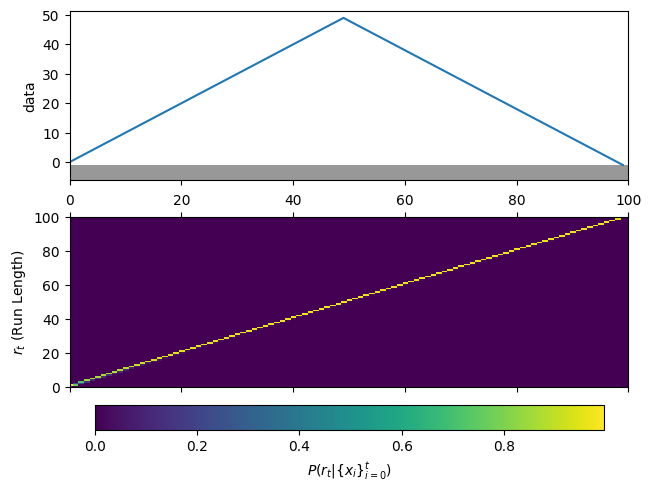

In [ ]:
# GPTS (Gaussian Process Time Series) Algorithm
'''
https://mlg.eng.cam.ac.uk/pub/pdf/SaaTurRas10.pdf
notes:
- x_t is observed value at time t
- r_t is the run time (time difference) between x_t-1 and x_t
- BOCPD is limited because it assumes knowledge of fixed parameters
- GPTS directly models the time series data directly from the time steps

GPTS:
- time index t input --> observation x_t output
    x_t = f(t) + epsilon_t
    f ~ GP(0, k) (gaussian process with mean 0 and some kernel/covariance k)
        common k is the "squared exponential" because it's infinitely differentiable (? maybe look into this)
    epsilon ~ normal(0, sigma^2_n)
  
- GPTS underlying predictive model gives a predictive distribution
    p(x_t | x_{(t-tau):(t-1)}, theta_m) = normal(m_t, v_t)
      t-tau : limit the memory window
      t-1 : up to the previous observation
      theta_m : comes from hyperparameter lambda = (xi; sigma^2_n)
      m_t = k_*^T (K + sigma^2_n I)^{-1} x
      v_t = k(x_t, x_t) - k_*^T (K + sigma^2_n I)^{-1} k_*^T
          x = x_(t-tau):(t-1) 
          --> previous tau observations
          k_* = k(x_{(t-tau):(t-1)}, x_t) 
          --> covariance (vector) between previous tau observations and current observation
          K = k(x_{(t-tau):(t-1)} , {(t-tau):(t-1)})
          --> covariance (matrix) of the previous tau observations with themselves

- Actually I think it's a better use of time to look for an implementation
    because they mentioned naive implementations would be O(T^5)
    and there's no reason for me to believe I wouldn't use a naive implementation
'''

# def getLikelihood(times, observations):
#     '''
#     Learning and Run Length Estimation in BOCPD (Bayesian Online Change Point Detection)

#     Algorithm 1 in https://mlg.eng.cam.ac.uk/pub/pdf/SaaTurRas10.pdf
#     '''
#     # init
    
#     # 

# wait lowkey I might be able to just use changepoint
# changepoint.ArgpCpd refers to Ryan Turner's thesis, and Ryan Turner is the author of the linked paper
# argp = autoregressive gaussian process
# cpd = change point detection
# code order stolen from the same notebook as above
# for now, we just use the default settings
argp = changepoint.ArgpCpd()
'''
ArgpCpd documentation:

scale: float
    Scale of the `ConstantKernel`
length_scale:float
    Length Scale of `RBFKernel`
noise_level: float
    Noise standard deviation for the `WhiteKernel`
max_lag: int > 0
    Maximum Autoregressive lag
alpha0 : float
    Scale Gamma distribution alpha parameter
beta0: float
    Scale Gamma distribution beta parameter
logistic_hazard_h: float
    Hazard scale in logit units.
logistic_hazard_a: float
    Roughly the slope of the logistic hazard function
logistic_hazard_b: float
    The offset of the logistic hazard function.

Default values:
scale=0.5,
length_scale=10.0,
noise_level=0.01,
max_lag=3,
alpha0=2.0,
beta0=1.0,
logistic_hazard_h=Ellipsis,
logistic_hazard_a=1.0,
logistic_hazard_b=1.0,
'''
# it's a little weird that we never actually use the times in this model
# I feel like a big point of the paper was that you can use the time differences to help the estimations
# ohhh ok looking back, it's not about the time and more about the run length
# so like how long the current process has been stable kind of?
change_point_history = np.zeros((n+1,n+1))

for i, x in enumerate(y_data):
    cps = argp.step(x)
    change_point_history[i, :len(cps)] = cps

_, _, change_points = change_point_plot(y_data, change_point_history)
print(f"Change points detected at indices: {change_points}")
# plt.plot(change_point_history)
plt.show()

It looks like the run just continued going, so no change points were detected.

## Slope data adjustments
The change point detection did not automatically find when the slope changed in the observations, but this is not particularly surprising in hindsight. Since we have a Gaussian process, the slopes just describe how much the data has changed relative to the previous (however many steps it looks at; by default 3) steps. It never really leaves the distribution, even at the sharp slope difference.

The next thing to try is manually computing slopes (deltas). I expect this to work since there will be a sharp difference in mean relative to the previous 3 steps.

The nice thing about Gaussian processes is that they should also be able to detect changes in variation, but this is just an initial experiment to make sure things work as intended.

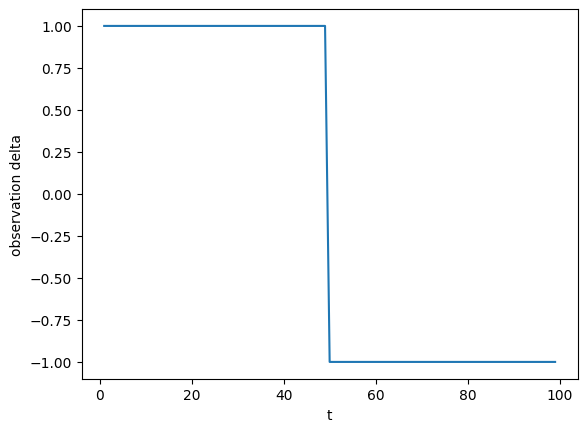

In [56]:
# there is a clear change in slope, so we model that instead
slopes = np.zeros(n-1)
for i in range(1,n):
    slopes[i-1] = y_data[i] - y_data[i-1]

slope_times = x_data[1:]
plt.plot(slope_times, slopes)
plt.xlabel("t")
plt.ylabel("observation delta")
plt.show()

Change points detected at indices: [  0  48 100]


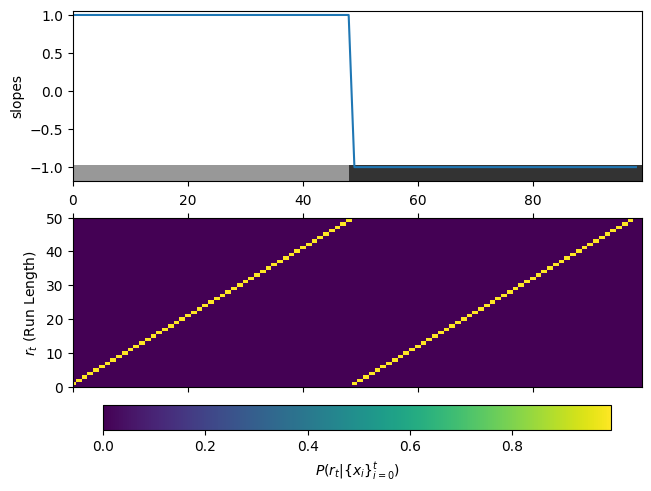

In [60]:
argp = changepoint.ArgpCpd()
change_point_history = np.zeros((n+1,n+1))

for i, x in enumerate(slopes):
    cps = argp.step(x)
    change_point_history[i, :len(cps)] = cps

_, (data_ax, _data_ax), change_points = change_point_plot(slopes, change_point_history)
print(f"Change points detected at indices: {change_points}")
# plt.plot(change_point_history)
data_ax.set_ylabel("slopes")
plt.show()

Indeed, the model picked up the change point at time $t=48$. Based on the data generation, this is exactly when the change happened ($t=49$ was the last instance of slope=1, and all indices shifted back 1 when we found the differential) When dealing with the time series data, we can use the change points to index the event at which the change was observed; the event will give us a timestamp for the change, and we can search for events that happened close to that event. More to come...